# Imports

In [2]:
import jax.numpy as jnp
import jax
import optax
import functools
import jax.random as r
import flax

# MNIST tutorial

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

2024-10-23 10:01:19.702129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 10:01:20.444124: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 10:01:20.614550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 10:01:34.663025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
tf.random.set_seed(0)

train_steps = 1200
eval_every = 200
batch_size = 32

train_ds : tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

mapper = lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255.,
    'label': sample['label'],
}
train_ds = train_ds.map(mapper)
test_ds = test_ds.map(mapper)

train_ds = train_ds.repeat().shuffle(1024)
# Group into batches of `batch_size` and skip incomplete batches, prefetch the 
# next sample to improve latency
train_ds = train_ds.batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)
test_ds = test_ds.batch(batch_size).prefetch(1)

In [5]:
from flax import nnx
from functools import partial

In [6]:
class CNN(nnx.Module):
    """A simple CNN model."""

    def __init__(self, *, rngs: nnx.Rngs):
        # to do
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3,3), rngs=rngs)
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3,3), rngs=rngs)
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
        self.linear2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x):
        x = self.avg_pool(nnx.relu(self.conv1(x)))
        x = self.avg_pool(nnx.relu(self.conv2(x)))
        x = x.reshape(x.shape[0], -1) # flatten
        x = nnx.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [7]:
# Instantiate the model.
model = CNN(rngs=nnx.Rngs(0))
# Visualise it
nnx.display(model)

CNN(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x7f4074395480>,
    bias_init=<function zeros at 0x7f40c791cd30>,
    conv_general_dilated=<function conv_general_dilated at 0x7f40c7e2b640>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_di

In [8]:
y = model(jnp.ones((1, 28, 28, 1)))
nnx.display(y)

[[-0.06820834 -0.14743432  0.00265852 -0.21736552  0.16673796 -0.00923909
  -0.06636676  0.28341877  0.3375435  -0.20142873]]


In [9]:
import optax
learning_rate = 0.005
momentum = 0.9

optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))
metrics = nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(),
    loss=nnx.metrics.Average('loss'),
)
nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=CNN(
    conv1=Conv(
      kernel_shape=(3, 3, 1, 32),
      kernel=Param(
        value=Array(shape=(3, 3, 1, 32), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(32,), dtype=float32)
      ),
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x7f4074395480>,
      bias_init=<function zeros at 0x7f40c791cd30>,
      conv_general_dilated=<function conv_general_dilated at 0x7f40c7e2b640>
    ),
    conv2=Conv(
      kernel_shape=(3, 3, 32, 64),
      kernel=Param(
        value=Array(shape=(3, 3, 32, 64), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(64

In [10]:
def loss_fn(model: CNN, batch):
    logits = model(batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']
    ).mean()
    return loss, logits

@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
    """Train for a single step"""
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label']) # In place updates
    optimizer.update(grads) # In place updates

@nnx.jit
def eval_step(model: CNN, metrics: nnx.MultiMetric, batch):
    loss, logits = loss_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch['label']) # In place updates
    

In [11]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': [],
}

Some questions / thoughts to consider:
- train_ds and test_ds get passed through as_numpy_iterator; does this mean return plain numpy arrays? presume that jax/flax then automatically converts these to numpy?

In [13]:
for step, batch in enumerate(train_ds.as_numpy_iterator()):
    # Run the optimization for one step and make stateful update to
    # model, optimizer, and metrics
    train_step(model, optimizer, metrics, batch)

    if step > 0 and (step % eval_every == 0 or step == train_steps - 1):
        # Log training metrics
        for metric, value in metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # Compute metrics on test set
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metrics, test_batch)

        # Log the test metrics.
        for metric, value in metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset()

        print(
            f"[train] step: {step}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] step: {step}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )


[train] step: 200, loss: 0.1190311461687088, accuracy: 96.04430389404297
[test] step: 200, loss: 0.08968482166528702, accuracy: 97.38999938964844
[train] step: 400, loss: 0.10440880060195923, accuracy: 96.984375
[test] step: 400, loss: 0.0835433080792427, accuracy: 97.2699966430664
[train] step: 600, loss: 0.08121555298566818, accuracy: 97.546875
[test] step: 600, loss: 0.05268009006977081, accuracy: 98.27999877929688
[train] step: 800, loss: 0.07464923709630966, accuracy: 97.59375
[test] step: 800, loss: 0.0654367133975029, accuracy: 98.02999877929688
[train] step: 1000, loss: 0.07297688722610474, accuracy: 97.765625
[test] step: 1000, loss: 0.06266036629676819, accuracy: 98.0


2024-10-23 10:31:11.312092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


[train] step: 1199, loss: 0.06425396353006363, accuracy: 98.08416748046875
[test] step: 1199, loss: 0.07687821239233017, accuracy: 97.56999969482422


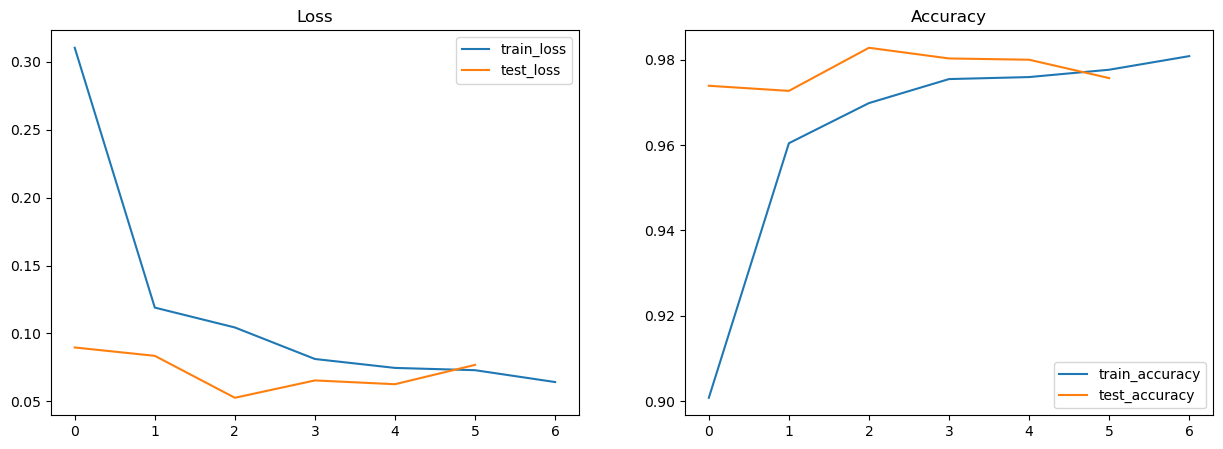

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
    ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
    ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')

ax1.legend()
ax2.legend()
plt.show()

## 10. Inference on the test set

In [16]:
model.eval() # Switch to evaluation mode

@nnx.jit
def pred_step(model: CNN, batch):
    logits = model(batch['image'])
    return logits.argmax(axis=1)

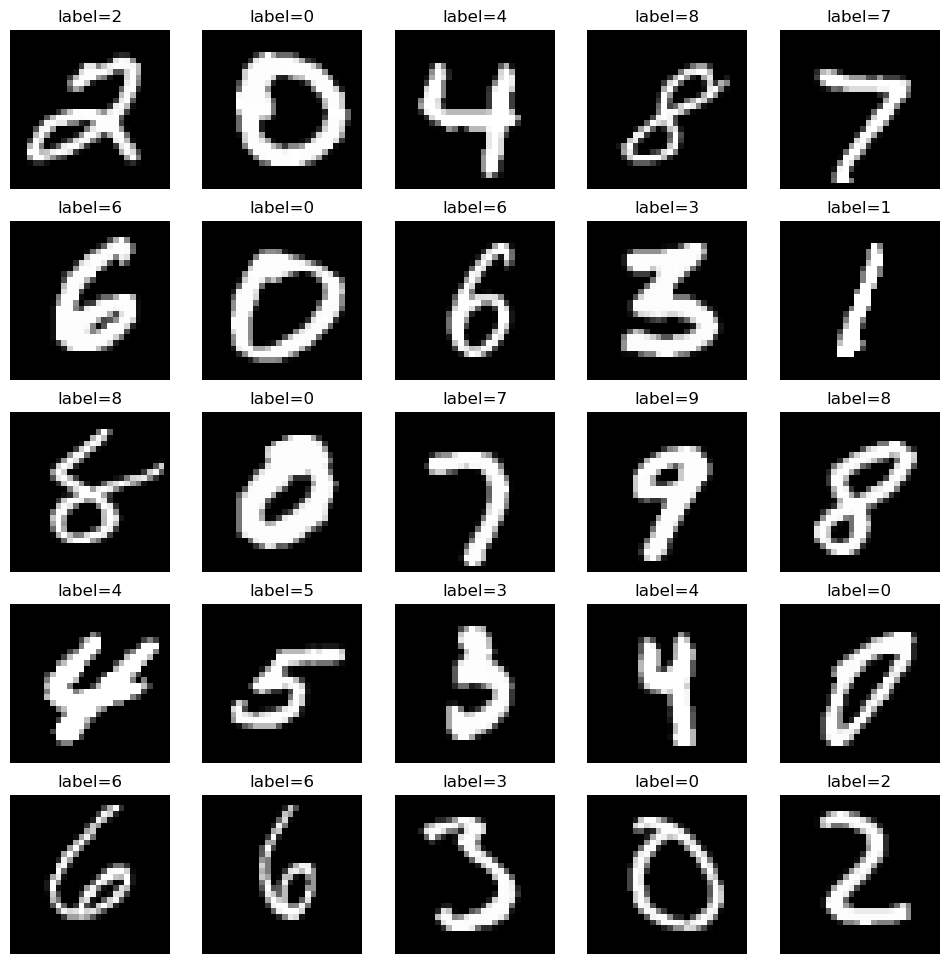

In [17]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')

In [24]:
test_batch['image'][0].shape

(28, 28, 1)

In [29]:
import flax
flax.__version__

'0.10.0'

In [25]:
nnx.Conv?

Init signature: nnx.Conv(*args: 'Any', **kwargs: 'Any') -> 'Any'
Docstring:     
Convolution Module wrapping ``lax.conv_general_dilated``.

Example usage::

  >>> from flax import nnx
  >>> import jax.numpy as jnp

  >>> rngs = nnx.Rngs(0)
  >>> x = jnp.ones((1, 8, 3))

  >>> # valid padding
  >>> layer = nnx.Conv(in_features=3, out_features=4, kernel_size=(3,),
  ...                  padding='VALID', rngs=rngs)
  >>> layer.kernel.value.shape
  (3, 3, 4)
  >>> layer.bias.value.shape
  (4,)
  >>> out = layer(x)
  >>> out.shape
  (1, 6, 4)

  >>> # circular padding with stride 2
  >>> layer = nnx.Conv(in_features=3, out_features=4, kernel_size=(3, 3),
  ...                  strides=2, padding='CIRCULAR', rngs=rngs)
  >>> layer.kernel.value.shape
  (3, 3, 3, 4)
  >>> layer.bias.value.shape
  (4,)
  >>> out = layer(x)
  >>> out.shape
  (1, 4, 4)

  >>> # apply lower triangle mask
  >>> mask = jnp.tril(jnp.ones((3, 3, 4)))
  >>> layer = nnx.Conv(in_features=3, out_features=4, kernel_size=(3

In [32]:
# where does 3136 come from?  
28 * 28 * 64 / 4**2

3136.0

Question: what is a good architecture? want to blow up; but then would have a heap of parameters early on.  
Guess for now: just blow up then do some smoothing like operation with the convolutional layer

Answer from tutorial is that can use a Conv2DTranspose in Keras.  
They also use MVNTriL, and this is compatible with Keras sequential.  
Some things to investigate:  
- can a distribution be the output of nnx.Module? (i.e. we actually output the distribution straight off)  
- is there a Conv2DTranspose in flax?
- how does the tutorial code do backprop with respect to the decoder weights?

Backprop: in the tutorial they optimise the neg_log_lik function.  
This takes pair as input.  
Calls vae.fit; so guess have to have inputs and outputs automatically used.  
But t